In [1]:
from importlib import reload
import platform, os, sys, datetime, re, itertools, warnings, pickle, bz2
from os.path import join
from glob import glob
import cv2
import numpy as np
from scipy.signal import find_peaks
import pandas as pd
import matplotlib.pyplot as plt
import tracker.utils as utils
from collections import defaultdict

plt.rcParams['figure.figsize'] = 9,6
# plt.rcParams['figure.dpi'] = 150
dpi = 150

analysis_dir = './analysis'

# Prepare trial data.

Prepare a dictionary of trials to analyze with basic info for each (path to trial file, population, age, number of individuals, etc).

In [7]:
tank_diameter_vs_age = { 7:9.6, 14:10.4, 21:12.8, 28:17.7, 42:33.8,
                         56:33.8, 70:33.8, 84:3.8 }

# Extract trial metadata from the trial's filename.
def parse_trial_file(trial_file, etho=False):
    if etho:
        trial_dir  = None
        trial_name = os.path.basename(trial_file)
        trial_name = trial_name.split('-')[1]
    else:
        trial_dir  = os.path.dirname(trial_file)
        trial_name = os.path.basename(trial_dir)
    pop,day,age,group,n_ind = trial_name.split('_')[:5]
    pop        = {'sf':'SF', 'pa':'Pa', 'rc':'RC'}[pop.lower()]
    age        = int(age[:-3])
    age = 42 if age==43 else (70 if age==71 else age)
    n_ind      = int(re.findall('\d+',n_ind)[0])
    R_cm       = tank_diameter_vs_age[age]/2
    trial      = { k:v for k,v in locals().items() if k in ['trial_dir', 
                   'trial_name', 'pop', 'age', 'group', 'n_ind', 'R_cm'] }
    return trial


# Select a set of trials to analyze.
trial_files = sorted(glob('../tracking/full_21-01-22/*/trial.pik'))


# Count trials of each type.
trials = [ parse_trial_file(f) for f in trial_files]
trials = pd.DataFrame(trials,index=trial_files)
grouped_trials = trials.groupby(['pop','age','n_ind'])
count  = pd.DataFrame(grouped_trials['trial_dir'].count().rename('count'))
count = count.unstack(1)
count.columns = count.columns.droplevel()
count[pd.isna(count)] = 0
count = count.astype(int)
# print('Number of trials of each type:')
count

age        7   14  21  28  42  56  70  84
pop n_ind                                
Pa  1       8  11  15  15  10   4   9   5
    2      32  21  22  24  20  18  19  17
    4       0   0   0   0   0   1   0   0
    5      17  11   8  12   8  11  11  10
RC  1       5   2   2   2   6   4   4   4
    2       3   2   2   2   7  11  10   8
    5       2   2   2   2   5   3   3   3
SF  1       6  10  17  17   8   3   2   1
    2      23  20  17  19  15   7   6   5
    5      12  12  10  13   6   6   7   4

# Define analysis functions.

In [3]:
# def dist2ellipse(semi_major, semi_minor, xy):
#     px,py = np.absolute(xy)
#     tx,ty = 0.707,0.707
#     a = semi_major
#     b = semi_minor
#     for x in range(0, 3):
#         x   = a * tx
#         y   = b * ty
#         ex  = (a*a - b*b) * tx**3 / a
#         ey  = (b*b - a*a) * ty**3 / b
#         rx  = x - ex
#         ry  = y - ey
#         qx  = px - ex
#         qy  = py - ey
#         r   = np.hypot(ry, rx)
#         q   = np.hypot(qy, qx)
#         tx  = min(1, max(0, (qx * r / q + ex) / a))
#         ty  = min(1, max(0, (qy * r / q + ey) / b))
#         t   = np.hypot(ty, tx)
#         tx /= t 
#         ty /= t 
#     return (np.copysign(a * tx, xy[0]), np.copysign(b * ty, xy[1]))    


def compute_kinematics(trial,wall_distance=False):
    center      = trial['center']
    px2cm       = trial['R_cm']/trial['R_px']
    n           = trial['n_ind']
    pos         = trial['data'][:,:n,:3].copy() # discard extra objects
    pos[:,:,:2] = (pos[:,:,:2]-center[None,None,:])*px2cm # convert to centimeters
    pos[:,:,1]  = -pos[:,:,1] # flip y axis
    for j in range(n): # unwrap orientations
        I          = ~np.isnan(pos[:,j,2])
        pos[I,j,2] = np.unwrap(pos[I,j,2])
    time        = trial['frame_list']/trial['fps']
    vel         = np.gradient(pos,time,axis=0)
    acc         = np.gradient(vel,time,axis=0)
    v           = np.hypot(vel[:,:,0],vel[:,:,1])
    
    d_wall      = trial['R_cm'] - np.hypot(pos[:,:,0],pos[:,:,1])
# #     dist    = lambda xy: dist2ellipse(*ellipse[1],xy)
#     dist    = lambda xy: cv2.pointPolygonTest(trial['tank']['contour'],tuple(xy),True)
#     d_wall  = px2cm * np.apply_along_axis(dist,2,trial['data'][:,:,:2])
    
    trial.update({ k:v for k,v in locals().items() if k in 
                   ['time', 'pos', 'vel', 'acc', 'd_wall', 'v'] })
    return trial


def compute_cuts(trial,ranges):
    # Distances in ut ranges
    globals().update(trial)
    
    # valid array: axis 0 = time, axis 1 = [nan_xy,nan_any,d_wall,v,v_ang,final]
    valid  = np.full(pos.shape[:2]+(7,),np.True_,dtype=np.bool_)
    valid[:,:,0] = np.logical_not(np.any(np.isnan(pos),axis=2))
    valid[:,:,1] = np.logical_not(np.any(np.isnan(vel),axis=2))
    valid[:,:,2] = np.logical_not(np.any(np.isnan(acc),axis=2))
    valid[:,:,3] = np.logical_and(d_wall>=ranges['d_wall'][0],d_wall<=ranges['d_wall'][1])
    valid[:,:,4] = np.logical_and(v>=ranges['v'][0],v<=ranges['v'][1])
    valid[:,:,5] = np.logical_and(vel[:,:,2]>=ranges['v_ang'][0],vel[:,:,2]<=ranges['v_ang'][1])
    valid[:,:,6] = np.all(valid[:,:,:5],axis=2)
    
    n_total = valid.shape[0]*valid.shape[1]
    n_valid = np.count_nonzero(valid,axis=(0,1))
    valid_fraction = { 'nan_pos' : n_valid[0]/n_total, 
                       'nan_vel' : n_valid[1]/n_total, 
                       'nan_acc' : n_valid[2]/n_total, 
                       'd_wall'  : n_valid[3]/n_valid[0], 
                       'v'       : n_valid[4]/n_valid[1], 
                       'v_ang'   : n_valid[5]/n_valid[1], 
                       'final'   : n_valid[6]/n_total     }
    
    trial.update({'valid':valid, 'valid_fraction':valid_fraction, 'cut_label':cut_label})
    return trial


# t0 = datetime.datetime.now()
# trial = load_trial(trial_files[0], load_data=True)
# trial = compute_kinematics(trial)
# trial = compute_cuts(trial)
# print(datetime.datetime.now()-t0)

### [in progress] Detect discrete turns.

In [4]:
# for i,trial_file in enumerate(trials.index):
#     trial = load_trial(trial_file, load_data=True)
#     trial = compute_kinematics(trial)
#     locals().update(trial)
#     print('\r'+' '*200+'\r'+f'{i}/{len(trial_files)}  {trial_name}',end='')
#     # Plot angle.
#     a = pos[:,0,2]
#     plt.plot(time,a,label='actual angle')
#     # Extract discrete turns.
#     w = int(0.1*fps)
#     step = np.concatenate([np.ones(w)/w,np.zeros(1),-np.ones(w)/w])
#     conv = np.convolve(a,step,mode='same')
#     P = find_peaks(np.absolute(conv),distance=w,height=np.pi/25)
#     # Reconstruct angle vs time using only the discrete turns.
#     da = np.zeros_like(a)
#     da[P[0]] = conv[P[0]]
#     a2 = a[0]+np.cumsum(da)
#     plt.plot(time,a2,label='reconstructed angle')
    
#     plt.plot(time,a-a2,label='actual angle - reconstructed angle')
    
# #     plt.xlim(0,1000)
# #     plt.ylim(2,15)
#     plt.legend()
    
#     break

In [5]:
# fig,ax = plt.subplots(1,2,figsize=(12,4))
# I = P[0]
# dt = time[I[1:]]-time[I[:-1]]
# ax[0].hist(dt,bins=50)
# ax[0].set_xlabel('time between two discrete turns')
# ax[0].set_ylabel('frequency')
# ax[0].set_yscale('log')
# ax[1].hist(np.absolute(conv[I]),bins=50)
# ax[1].set_xlabel('angle turned')
# ax[1].set_yscale('log')
# plt.suptitle('Discrete turns')
# plt.show()


# fig,ax = plt.subplots(1,2,figsize=(12,4))
# da = np.diff(a-a2)/np.sqrt(time[1:]-time[:-1])
# ax[0].hist(da,bins=100)
# ax[0].set_xlabel('da/sqrt(dt)')
# ax[0].set_ylabel('frequency')
# # dt = time[I[1:]]-time[I[:-1]]
# # ax[0].hist(dt,bins=20)
# # ax[1].hist(np.absolute(conv[I]),bins=50)
# # plt.xlim(-5,5)
# ax[0].set_yscale('log')
# ax[1].set_visible(False)
# plt.suptitle('Continuous turns')
# plt.show()

# Test loading trilab-tracker and ethovision data

### trilab-tracker

In [8]:
# trial_files = sorted(glob('../tracking/full_21-01-22/*/trial.pik'))
# f = trial_files[1]
f = '../tracking/full_21-01-22/Pa_Sun_21dpf_GroupC_n2a_20200621_1510/trial.pik'
print(f,'\n')

print(parse_trial_file(f),'\n')

trial = parse_trial_file(f)
trial.update(utils.load_trial(f))
trial = compute_kinematics(trial)
print(list(trial.keys()))
print(trial['data'].shape)

../tracking/full_21-01-22/Pa_Sun_21dpf_GroupC_n2a_20200621_1510/trial.pik 

{'R_cm': 6.4, 'n_ind': 2, 'group': 'GroupC', 'age': 21, 'pop': 'Pa', 'trial_name': 'Pa_Sun_21dpf_GroupC_n2a_20200621_1510', 'trial_dir': '../tracking/full_21-01-22/Pa_Sun_21dpf_GroupC_n2a_20200621_1510'} 

['R_cm', 'n_ind', 'group', 'age', 'pop', 'trial_name', 'trial_dir', 'input_video', 'output_dir', 'n_extra', 'fps', 'data', 'frame_list', 'tank', 'info', 'center', 'R_px', 'd_wall', 'v', 'acc', 'vel', 'time', 'pos']
(36000, 2, 5)


../tracking/full_21-01-22/Pa_Sun_21dpf_GroupC_n2a_20200621_1510
../tracking/full_21-01-22/Pa_Sun_21dpf_GroupC_n2a_20200621_1510


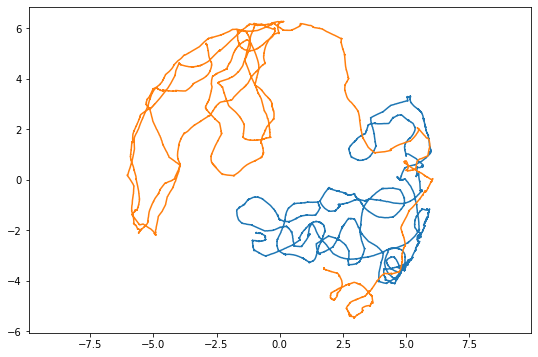

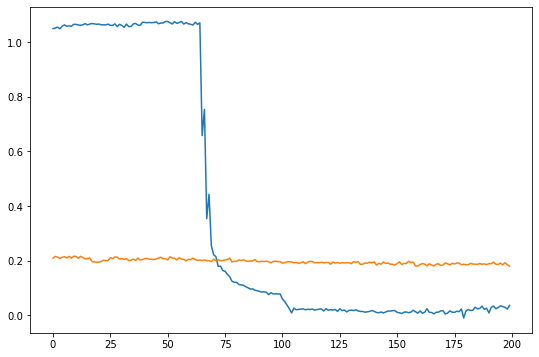

In [28]:
globals().update(trial)

print(output_dir)
print(trial_dir)

for i in range(n_ind):
    plt.plot(*pos[:,i,:2].T)
plt.axis('equal')
plt.show()

for i in range(n_ind):
    plt.plot(pos[:200,i,2],'-')
plt.show()

### ethovision

In [21]:
import tracker
reload(tracker.utils)
from tracker import utils

etho_files = glob('../ethovision/Raw_Data/*.xlsx')
f = etho_files[1]
print(f,'\n')

print(parse_trial_file(f, etho=True),'\n')

trial = utils.load_trial_ethovision(f)

../ethovision/Raw_Data/Raw data-Pa_Sun_21dpf_GroupC_n2a_2020-06-28-151111-0000-Trial     1.xlsx 

{'R_cm': 6.4, 'n_ind': 2, 'group': 'GroupC', 'age': 21, 'pop': 'Pa', 'trial_name': 'Pa_Sun_21dpf_GroupC_n2a_2020', 'trial_dir': None} 



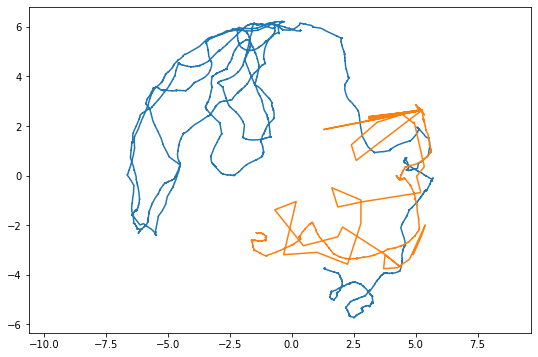

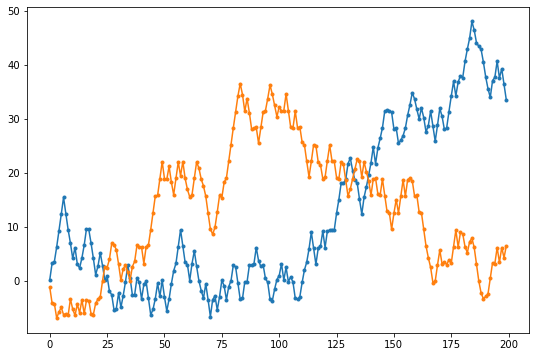

In [27]:
globals().update(trial)

for i in range(n_ind):
    plt.plot(*data[:,i,:2].T)
plt.axis('equal')
plt.show()

for i in range(n_ind):
    plt.plot(data[:200,i,2],'.-')
plt.show()

# Compute or load analyzed data.

The first subsection iterates over the list of trials, loads the full tracking output, compute kinematic quantities, performs cuts, computes statistical properties (distribution of speed, angular speed, pairwise distance-angle, etc), and saves them.

The second subsection loads precomputed statistical properties made with the first cell.

### Define cuts.

In [ ]:
# Speed cut: 0.2*30 = travel 0.2 tank radius between 2 frames at 30fps.
# Angular speed cut: pi/2*30 = quarter turn between 2 frames at 30 fps.
cut_ranges    = { 'd_wall':[-np.inf,np.inf], 'v':[0,0.2*30], 
                  'v_ang':[-np.pi/2*30,np.pi/2*30] }
# This is used to name the output directory and make figure titles.
# The "=" should be "<=" however ntfs doesn't allow "<" in filenames.
cut_label     = ', '.join([ f'{v[0]:g}={k}={v[1]:g}' for k,v in cut_ranges.items() ])

cut_dir = os.path.join(analysis_dir,cut_label)
if not os.path.exists(cut_dir):
    os.mkdir(cut_dir)

### Analyze trials.

In [ ]:
# bins_area     = np.linspace(0,600,100)
# bins_aspect   = np.linspace(1,15,100)
# prebins_dWall = np.linspace(-0.1,1.1,100) # Multiply by R_cm before using.
# prebins_v     = np.linspace(*cut_ranges['v'],100) # Multiply by R_cm before using.
# bins_vAng     = np.linspace(*cut_ranges['v_ang'],100)
# prebins_pairDist = np.linspace(0,2,60) # Multiply by R_cm before using.
# bins_pairAng  = np.linspace(0,np.pi,30)

# trial_data    = {}

# for i,trial_file in enumerate(trials.index):
#     print('\r'+' '*200+'\r'+f'{i+1}/{len(trials)}',end='')
    
#     trial  = load_trial(trial_file, load_data=True)
#     ranges = { 'd_wall': [ x*trial['R_cm'] for x in cut_ranges['d_wall'] ], 
#                'v':      [ x*trial['R_cm'] for x in cut_ranges['v'] ], 
#                'v_ang':  cut_ranges['v_ang'] }
#     trial  = compute_kinematics(trial)
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore", category=RuntimeWarning)
#         trial = compute_cuts(trial, ranges)
#     globals().update(trial)
    
#     # Fish area and Fish aspect ratio histograms.
#     # Useful to tune the tracker's contour filters.
#     hist_area   = np.histogram(data[:,:n_ind,3], bins=bins_area )
#     hist_aspect = np.histogram(data[:,:n_ind,4], bins=bins_aspect )
    
#     # Distribution of distance to the wall.
#     bins = prebins_dWall * R_cm
#     vals = d_wall.flatten()
#     hist_dWall = np.histogram(vals[~np.isnan(vals)],bins=bins)
    
#     # Speed distribution.
#     bins = prebins_v * R_cm
#     vals = v.flatten()
#     hist_v = np.histogram(vals[~np.isnan(vals)],bins=bins)
    
#     # Angular speed distribution.
#     bins = bins_vAng
#     vals = vel[:,:,2].flatten()
#     hist_vAng = np.histogram(vals[~np.isnan(vals)],bins=bins)
    
#     # Joint distribution of pair distance and pair angle,
#     if n_ind>1:
#         bins_d  = prebins_pairDist * R_cm
#         bins_a  = bins_pairAng
#         J1,J2 = np.triu_indices(n_ind,1)
#         d     = np.hypot(pos[:,J1,0]-pos[:,J2,0],pos[:,J1,1]-pos[:,J2,1]).flatten()
#         a     = (pos[:,J1,2]-pos[:,J2,2]).flatten()
#         a     = a - 2*np.pi*np.rint(a/(2*np.pi))
#         I     = np.logical_not(np.logical_or(np.isnan(d),np.isnan(a)))
#         d     = d[I]
#         a     = np.absolute(a[I])
#         # 2D histogram of pairwise distance and angle.
#         hist_distAng = np.histogram2d(d, a, bins=(bins_d,bins_a), density=True)
#         # Pairwise polar alignment parameter vs pair distance.
#         K = np.digitize(d,bins_d)
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore", category=RuntimeWarning)
#             p = np.array([ np.nanmean(np.cos(a[K==i])) for i in range(len(bins_d)+1) ])
#         polar = p[1:-1],bins_d
#     else:
#         hist_distAng,polar = None,None

#     # Save output.
#     trial_data[trial_file] = { k:v for k,v in locals().items() if k in 
#                                [ 'valid_fraction', 'hist_area', 'hist_aspect', 'hist_dWall', 
#                                  'hist_v', 'hist_vAng', 'hist_distAng', 'polar' ] }
# #     break


# f = os.path.join(cut_dir,'trial_data')
# # pickle.dump( {'trial_data':trial_data}, bz2.BZ2File(f+'.bz2','w') )
# pickle.dump( {'trial_data':trial_data}, open(f+'.pik','wb') )

### Load precomputed analysis results.

In [ ]:
# List previously computed cuts.
cut_dirs = os.listdir(analysis_dir)
print(cut_dirs)
cut_label = cut_dirs[0]

f    = os.path.join(analysis_dir,cut_label,'trial_data')
data = pickle.load( open(f+'.pik','rb') )
globals().update(data)

# Plot individual trial data

Distributions and other statistical quantities were precomputed in the previous section. Time series and trajectories plots require to reload each trial's trial file, one at a time.

### Trajectories and time series

In [ ]:
# fig_dir = { k:os.path.join(analysis_dir,cut_label,k) for k in 
#                ['trajectories', 'angle-vs-time'] }
# for d in fig_dir.values():
#     if not os.path.exists(d):
#         os.mkdir(d)

# # Creating a new figure for each trial creates a memory leak
# # I haven't been able to plug, so I'm creating one figure for
# # trajectories and one for angles and reusing them.
# fig_traj = plt.figure(figsize=(9,)*2)
# fig_ang  = plt.figure(figsize=(12,6))

# for i,trial_file in enumerate(trials.index):
#     print('\r'+' '*200+'\r'+f'{i+1}/{len(trials)}',end='')
    
#     trial = load_trial(trial_file, load_data=True)
#     trial = compute_kinematics(trial)
#     globals().update(trial)
    
#     # Trajectories.
#     fig,ax = fig_traj,fig_traj.gca()
#     ax.add_patch(plt.Circle(center, R_px, facecolor='None', 
#                                    edgecolor='k', lw=0.5))
#     ax.plot(*np.moveaxis(data[::5,:n_ind,:2],2,0),lw=0.5)
#     ax.axis('equal')
#     ax.yaxis.set_inverted(True)
#     fig.suptitle(trial_name)
#     fig.savefig(os.path.join(fig_dir['trajectories'],trial_name+'.png'))
#     fig.clf()
    
#     # Angle vs time.
#     fig,ax = fig_traj,fig_traj.gca()
#     ax.plot(time[:,None],pos[:,:,2])
#     ax.set_xlabel('Time (s)')
#     ax.set_ylabel('Angle (rad)')
#     fig.suptitle(trial_name)
#     fig.savefig(os.path.join(fig_dir['angle-vs-time'],trial_name+'.png'))
#     fig.clf()
    
# plt.close('all')

### Statistics

In [ ]:
# f    = os.path.join(analysis_dir,cut_label,'trial_data')
# data = pickle.load( open(f+'.pik','rb') )
# globals().update(data)

# fig_dir = { k:os.path.join(analysis_dir,cut_label,k) for k in [ #'valid_fraction', 
#             'hist_dWall', 'hist_v', 'hist_vAng', 'hist_distAng', 'polar' ] }
# for d in fig_dir.values():
#     if not os.path.exists(d):
#         os.mkdir(d)


# fig = plt.figure()
# ax  = fig.gca()

# for i,trial_file in enumerate(trials.index):
#     print('\r'+' '*200+'\r'+f'{i+1}/{len(trials)}',end='')
    
#     globals().update(trials.loc[trial_file].to_dict())
#     globals().update(trial_data[trial_file])
    
# #     # Valid fraction.
# #     bp = plt.bar(*zip(*valid_fraction.items()))
# #     for bar in bp:
# #         h,x,w = bar.get_height(),bar.get_x(),bar.get_width()
# #         plt.annotate(f'{h:.2f}', xy=(x+w/2,1.01), ha='center', va='bottom')
# #     plt.ylim(0,1.1)
# #     plt.ylabel('Valid fraction')
# #     plt.title(cut_label)
# #     plt.suptitle(trial_name)
# #     plt.savefig(os.path.join(fig_dir['valid_fraction'],trial_name+'.png'))
# #     plt.close()
    
#     # Distributions of distance to the wall, speed, and angular speed.
#     H = dict( hist_dWall='d_wall (cm)', hist_v='v (cm/s)', hist_vAng='v_ang (rad/s)' )
#     for name,label in H.items():
#         ax = fig.gca()
#         h,b = locals()[name]
#         ax.bar(b[:-1],h,width=b[1:]-b[:-1])
#         ax.set_yscale('log')
#         ax.set_xlabel(label)
#         ax.set_ylabel('frequency')
#         ax.set_title(cut_label)
#         fig.suptitle(trial_name)
#         fig.savefig(os.path.join(fig_dir[name],trial_name+'.png'))
#         fig.clf()
    
#     # Pairwise distance-angle distribution.
#     if not hist_distAng is None:
#         ax = fig.gca()
#         h,b1,b2 = hist_distAng
#         m = ax.pcolormesh(b1, b2*180/np.pi, h.T, cmap='Oranges')
#         ax.set_xlabel('pair distance (cm)')
#         ax.set_ylabel('pair angle (deg)')
#         fig.colorbar(m)
#         ax.set_title(cut_label)
#         fig.suptitle(trial_name)
#         fig.savefig(os.path.join(fig_dir['hist_distAng'],trial_name+'.png'))
#         fig.clf()
    
#     # Pairwise polar order parameter vs distance.
#     if not polar is None:
#         ax = fig.gca()
#         p,b = polar
#         ax.plot((b[1:]+b[:-1])/2,p,marker='o',mfc='None',ms=4)
#         ax.set_xlabel('pair distance (cm)')
#         ax.set_ylabel('mean cosine of pair angle')
#         ax.set_ylim(-1,1)
#         ax.set_title(cut_label)
#         fig.suptitle(trial_name)
#         fig.savefig(os.path.join(fig_dir['polar'],trial_name+'.png'))
#         fig.clf()
    
# #     if i==10:
# #         break

# plt.close('all')

In [ ]:
# ''' Analyze instances of unusually high velocity. '''

# # At 30 fps, |v_ang|=30 (about where the rare peaks start) 
# # corresponds to about pi/3 in one frame.
# print('v_ang for pi/3 in (1/30) second:',np.pi/3*fps)

# print('Instances of unusually high v_ang:')
# for f in fish_list:
#     ang_diff  = df[f,'ang'].diff()
#     I = np.nonzero(np.absolute(ang_diff.values)>1)[0]
#     for i in I[:5]:
#         display(df[f,'ang'].iloc[i-1:i+2])